# Measles Outbreaks In European Countries 
## Exploratory Data Analysis
---

_Author: Preeya Sawadmanod_ 

In this notebook we are going to explore our datasets by looking into recent outbreaks as well as the total count of Measles outbreaks from 1999 to 2019. The goal is to identify a country that will be the most suited for our time series modeling. Additionally, we are going to create a Choropleth maps over time to show Measles outbreaks in Europe.

### Table of content
---
- [Import Packages](#Import-Packages) 
- [Recent Outbreaks](#Recent-Outbreaks)
- [Total count of Measles Outbreaks](#Total-count-of-Measles-Outbreaks)
- [Outbreaks over Time](#Outbreaks-over-Time) 
- [Mapping of Outbreaks](#Mapping-of-Outbreaks) 

### Import Packages 

Here are additional packages that might require installation for this notebook

In [1]:
# !pip install geopandas
# !pip install geoplot
# !pip install qgrid

In [2]:
#Import miscellaneous
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#Import processing tools
import pandas as pd 
import numpy  as np
import datetime 

#Import Visualization tools
import matplotlib.pyplot as plt
%matplotlib inline

#Mapping tools  
import geopandas
import geoplot
import contextily as ctx

#Tools for gif
import os
import imageio

Read in data set from [data cleaning notebook]('./1_data_cleaning.ipynb')

In [3]:
#Reading data 
outbreak = pd.read_csv('../data/measles.csv')

#Converting time column into date time object
outbreak['time'] = pd.to_datetime(outbreak['time'])

In [4]:
outbreak.head()

indicator       unit       time regioncode regionname    numvalue
0  Notification rate   N/1000000 1999-01-01         AT    Austria   250549.29
1  Notification rate   N/1000000 1999-01-01         DK    Denmark   188197.14
2  Notification rate   N/1000000 1999-01-01         EL     Greece  1581723.75
3  Notification rate   N/1000000 1999-01-01         FI    Finland        0.00
4  Notification rate   N/1000000 1999-01-01         IE    Ireland  1875666.86

### Recent Outbreaks

Looking at most recent outbreaks by first sorting values 

In [5]:
outbreak[outbreak['indicator'] == 'Reported confirmed cases'].sort_values(by=['time', 'numvalue'], ascending=False).head()

indicator unit       time regioncode regionname  \
24703  Reported confirmed cases    N 2019-08-01         IT      Italy   
24711  Reported confirmed cases    N 2019-08-01         RO    Romania   
24698  Reported confirmed cases    N 2019-08-01         FR     France   
24704  Reported confirmed cases    N 2019-08-01         LT  Lithuania   
24689  Reported confirmed cases    N 2019-08-01         BG   Bulgaria   

       numvalue  
24703      71.0  
24711      65.0  
24698      48.0  
24704      40.0  
24689      38.0

The most recent outbreaks in August in 2019 are going to be plotted into a bar chart

In [6]:
#Assigning new data frame to recent outbreaks
recent_outbreak = outbreak[outbreak['indicator'] == 'Reported confirmed cases'].sort_values(by=['time', 'numvalue'], ascending=False).head(15)

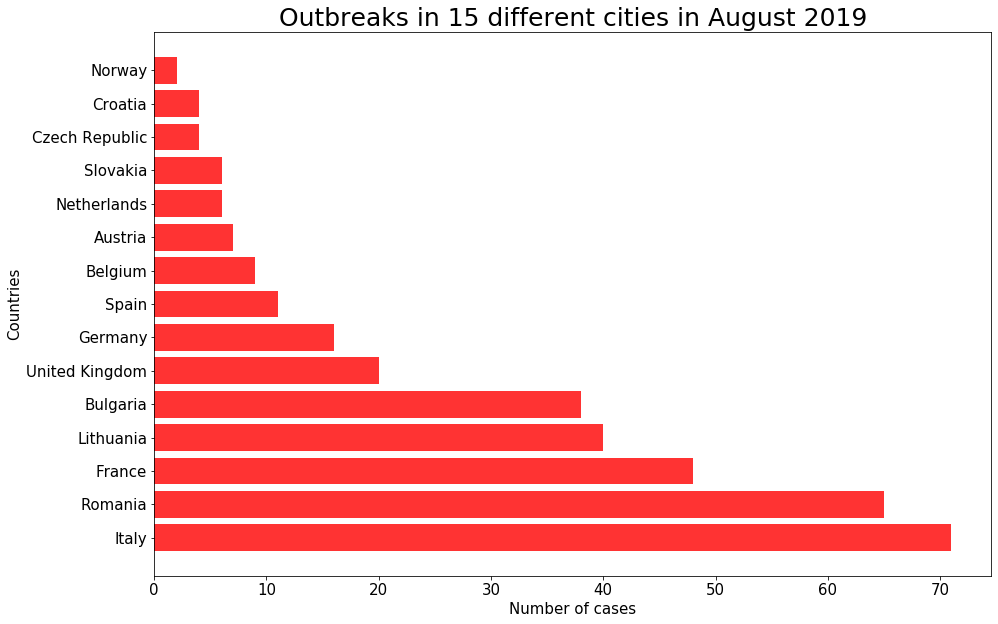

In [7]:
#Plotting Recent outbreaks in 15 different cities
plt.figure(figsize=(15,10))
plt.barh(recent_outbreak['regionname'], recent_outbreak['numvalue'], color='red', alpha=0.8, linewidth=5)

#Settings for figure such as labels, title and sizes
plt.tick_params(labelsize=15)
plt.xlabel("Number of cases", fontsize=15)
plt.ylabel("Countries", fontsize=15)
plt.title("Outbreaks in 15 different cities in August 2019", fontsize=25)

#Save plot
plt.savefig('../images/eda/recent_outbreaks.jpeg', pad_inches='tight', optimiza=True);

**Observation:**

As we can see in the plot, France, Romania and Italy had the most Measles outbreaks in August 2019, where the counts of confirmed reported cases were more than 50 cases. Further, we are going to look into the total count of outbreak in different countries

### Total count of Measles Outbreaks 

In [8]:
#Assigning a new data frame to all reported confirmed cases from 1999 to 2019
reported = outbreak.loc[outbreak['indicator'] == 'Reported confirmed cases',:]

#Creating a series with the 15 most recent outbreaks 
recent_outbreak_region = recent_outbreak['regionname'][:15]
recent_outbreak_region

24703             Italy
24711           Romania
24698            France
24704         Lithuania
24689          Bulgaria
24715    United Kingdom
24692           Germany
24696             Spain
24688           Belgium
24687           Austria
24707       Netherlands
24714          Slovakia
24691    Czech Republic
24699           Croatia
24708            Norway
Name: regionname, dtype: object

In [9]:
#Filtering all reported confirmed cases with series of most recent outbreaks
recent_out_region = reported[reported['regionname'].isin(recent_outbreak_region)]

#Total count of outbreaks in the 15 most recent outbreaks countries
recent_out_region = recent_out_region.groupby('regionname').sum()

#Sorting values 
recent_out_region = recent_out_region.sort_values(by='numvalue', ascending= False)
recent_out_region

numvalue
regionname              
Italy            59361.0
Bulgaria         23936.0
Romania          16342.0
United Kingdom   13823.0
France           13027.0
Germany          11717.0
Spain             5221.0
Belgium           1458.0
Netherlands       1253.0
Czech Republic    1168.0
Austria            993.0
Lithuania          985.0
Slovakia           678.0
Croatia            218.0
Norway             145.0

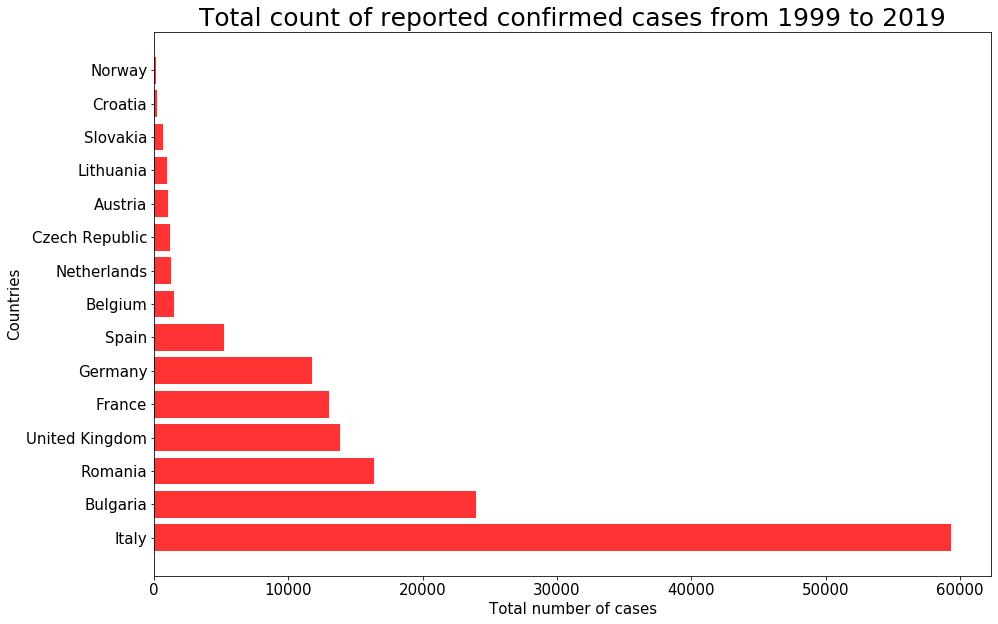

In [10]:
#Plottting all reported confirmed cases and recent countries where recent outbreaks occured
plt.figure(figsize=(15,10))

# #Countplot of reported confirmed cases from 1999 to 2019 
plt.barh(recent_out_region.index, recent_out_region['numvalue'], color='red', alpha=0.8, linewidth=5);

#Settings for figure such as labels, title and sizes
plt.tick_params(labelsize=15)
plt.xlabel("Total number of cases", fontsize=15)
plt.ylabel("Countries", fontsize=15)
plt.title("Total count of reported confirmed cases from 1999 to 2019", fontsize=25)

#Save plot
plt.savefig('../images/eda/total_count_outbreaks.jpeg', pad_inches='tight', optimiza=True);

**Observation**: 

In this plot, we can see that Germany, France, UK, Romania, Bulgaria and Italy are the top 6 countries with the most Measles outbreaks from 1999 to 2019. As already indicated in the previous plot above, these countries also have had recent outbreaks. Therefore, we are going to look further into these top 6 countries to find a country that will be best suited for our time series models.

### Outbreaks over Time

We are going to look at the top 6 countries and compare the outbreaks over time to identify a country, where we will able to model a times series with it. 

In [11]:
#Mask for indicators for reported and reported confirmed cases
reported = outbreak['indicator'] == 'Reported cases'
confirmed = outbreak['indicator'] == 'Reported confirmed cases'

We are going to create a function to filter through the data frame and a second function for plotting

In [12]:
#Function for creating data frame for each country
def create_country(country):
    country = outbreak[outbreak['regionname'] == country]
    return country

In [13]:
#Function to plot the country of choice 
def plotting_country(df, title):     
    plt.figure(figsize=(18,7))
    #Plotting reported cases and confirmed cases
    plt.plot(df.loc[reported]['time'], df.loc[reported]['numvalue'], label= 'Number of reported cases', color='pink')
    plt.plot(df.loc[confirmed]['time'], df.loc[confirmed]['numvalue'], label= 'Number of confirmed cases', color='red', alpha=0.8)
    
    #Setting titles, legend, labels and ticks parameters 
    plt.title(f"Measles cases in {title}", fontsize=25)
    plt.legend(fontsize=15)
    plt.xlabel("Time in Years", fontsize=15)
    plt.ylabel("Number of cases", fontsize=15)
    plt.tick_params(labelsize=15)
    
    return 

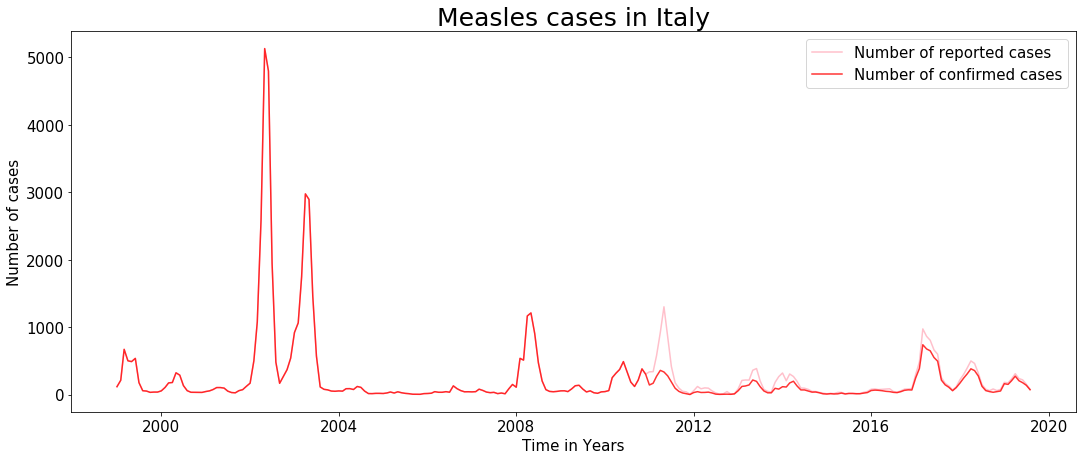

In [14]:
#Plotting Italy 
italy = create_country("Italy")
plotting_country(italy, "Italy")

**Observation:**

As shown in the plot, Italy had a major outbreak in 2002/2003, where the number of cases reported and confirmed are very high (approx. 5000). This can be considered as an Epidemic. However, ever since the Epidemic, the number of cases reported and confirmed has decreased. Additionally, there is significant overlap between numbers of reported and confirmed cases. Italy will not be best suited for our time series models.

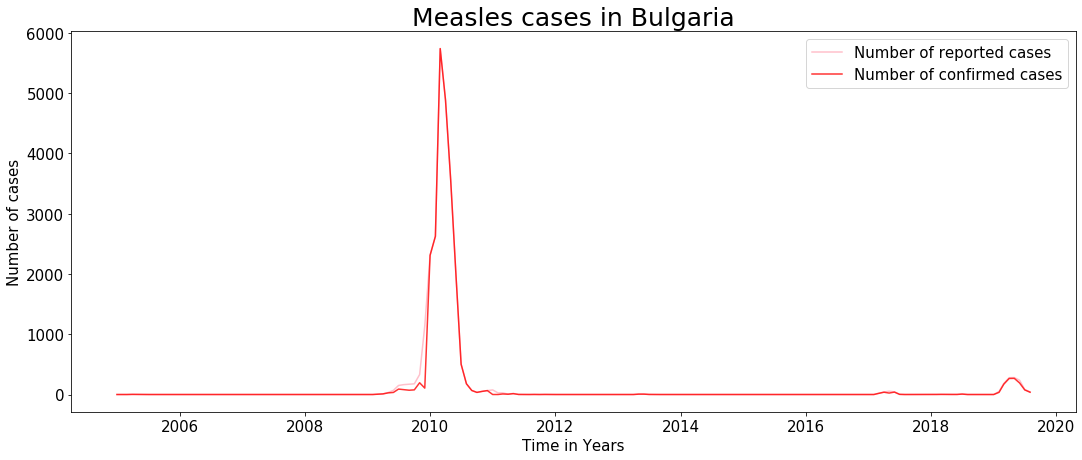

In [15]:
#Plotting Bulgaria
bulgaria = create_country("Bulgaria")
plotting_country(bulgaria, "Bulgaria")

**Observation:**

The number of reported cases are almost matching up with the number of confirmed cases here. Bulgaria had one major outbreak in the end of 2010 with more than 5500 cases. However, Bulgaria will not be suited for our time series models as it shows only one outbreak.

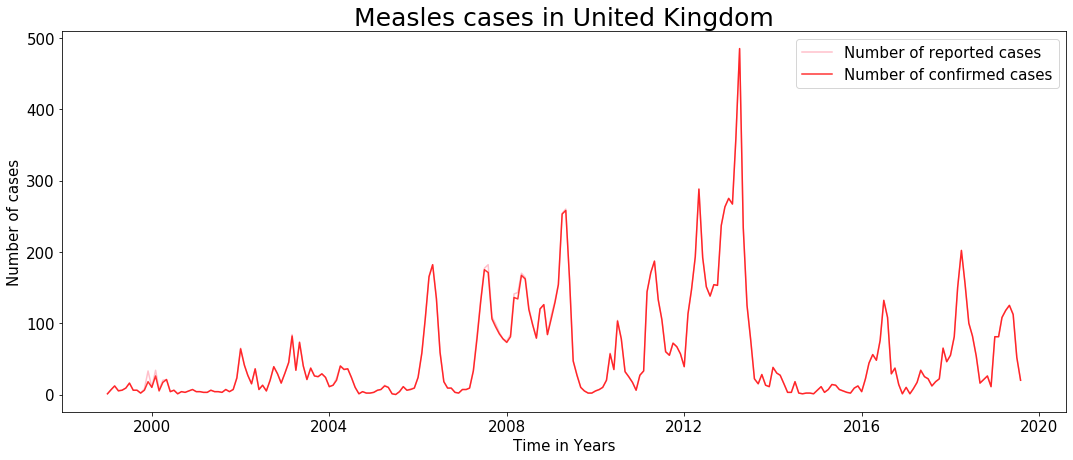

In [16]:
#Plotting UK 
uk = create_country("United Kingdom")
plotting_country(uk, "United Kingdom")

**Observation:** 

Like Italy, UK will also be not suited for our times series models as there is too much overlap between number of reported and confirmed cases, even though UK had frequent outbreaks.

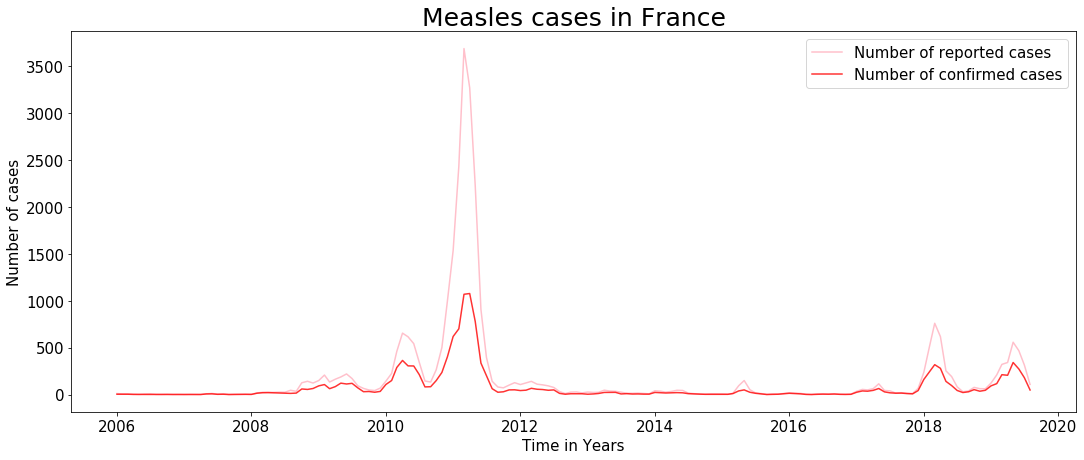

In [17]:
#Plotting France
france = create_country("France")
plotting_country(france, "France")

**Observation:** 

Like Bulgaria, France will not be suited for our model as there aren't many outbreaks that occurred over time.

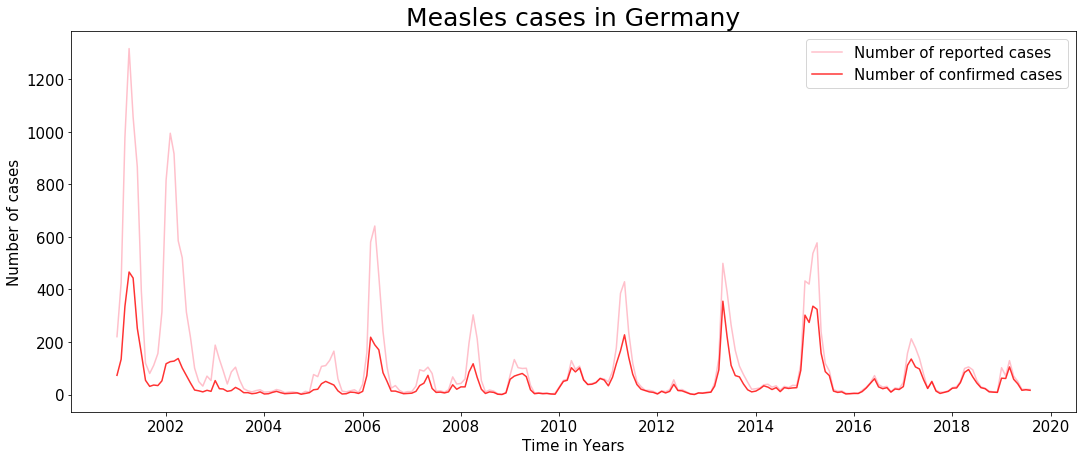

In [18]:
#Plottinger Germany
germany = create_country("Germany")
plotting_country(germany, "Germany")

#Save plot
plt.savefig('../images/eda/outbreaks_Germany.jpeg', pad_inches='tight', optimiza=True);

**Observation:** 

In Germany as shown in the plot, we can see many outbreaks over time with not too many overlap between the number of reported and confirmed cases. This country will be well suited for our times series models.

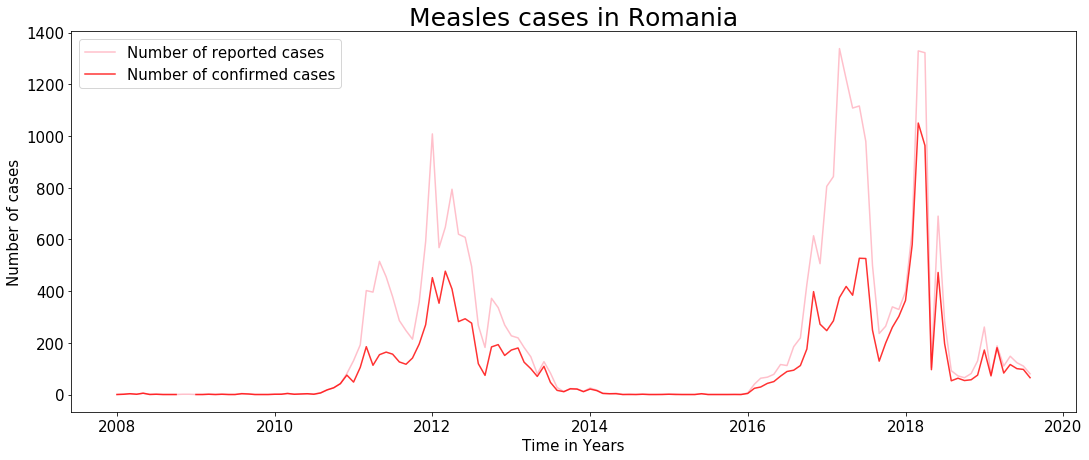

In [19]:
#Plotting Romania
romania = create_country("Romania")
plotting_country(romania, "Romania")

**Observation:** 

Romania is also well suited for our time series models as there are not many overlaps, however Germany had data starting from 2001, whereas Romania starts with 2008. Therefore we are going to continue with **Germany** as our target country for predictions.

### Mapping of Outbreaks

We are going to create a Chloropleth map of Measles outbreaks in European countries with GeoPandas. GeoPandas extends the datatypes used by pandas to allow spatial operations on geometric types

In [20]:
#Loading in world map from GeoPandas's data set
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.head()

pop_est      continent                      name iso_a3  gdp_md_est  \
0     920938        Oceania                      Fiji    FJI      8374.0   
1   53950935         Africa                  Tanzania    TZA    150600.0   
2     603253         Africa                 W. Sahara    ESH       906.5   
3   35623680  North America                    Canada    CAN   1674000.0   
4  326625791  North America  United States of America    USA  18560000.0   

                                            geometry  
0  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...  
1  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...  
2  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...  
3  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...  
4  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...

In [21]:
#Changing Coordinate Reference System (CRS) to a different projection coordinate system.
world = world.to_crs(epsg=3857)

This conversion is important as we want our maps to look like Google Maps. More information on EPSG can be found [here](https://epsg.io/3857)

In [22]:
#Filtering and assigning GeoPandas data frame for European countries
europe = world[world['continent'] == 'Europe']
europe.head()

pop_est continent     name iso_a3  gdp_md_est  \
18   142257519    Europe   Russia    RUS   3745000.0   
21     5320045    Europe   Norway    -99    364700.0   
43    67106161    Europe   France    -99   2699000.0   
110    9960487    Europe   Sweden    SWE    498100.0   
111    9549747    Europe  Belarus    BLR    165400.0   

                                              geometry  
18   MULTIPOLYGON (((19895609.388 11436139.118, 200...  
21   MULTIPOLYGON (((1685691.012 15333216.867, 1727...  
43   MULTIPOLYGON (((-5750519.703 463075.975, -5816...  
110  POLYGON ((1227561.058 8149359.996, 1276642.191...  
111  POLYGON ((3136616.945 7592158.584, 3253814.546...

In [23]:
#Expanding Multipolygon for european countries and resetting index
europe = europe.loc[europe['name'].isin(outbreak['regionname'])].explode()

#Resetting index
europe.reset_index(inplace=True)
europe.head()

level_0  level_1   pop_est continent    name iso_a3  gdp_md_est  \
0       21        0   5320045    Europe  Norway    -99    364700.0   
1       21        1   5320045    Europe  Norway    -99    364700.0   
2       21        2   5320045    Europe  Norway    -99    364700.0   
3       21        3   5320045    Europe  Norway    -99    364700.0   
4       43        0  67106161    Europe  France    -99   2699000.0   

                                            geometry  
0  POLYGON ((1685691.012 15333216.867, 1727962.36...  
1  POLYGON ((3462152.181 10926389.271, 3272742.93...  
2  POLYGON ((3050989.582 15574972.083, 2885918.89...  
3  POLYGON ((2752276.449 14290898.785, 2503610.97...  
4  POLYGON ((-5750519.703 463075.975, -5816369.64...

In [24]:
#Dropping previous index columns
europe.drop(columns=['level_0', 'level_1'], axis=1, inplace=True)
europe.head()

pop_est continent    name iso_a3  gdp_md_est  \
0   5320045    Europe  Norway    -99    364700.0   
1   5320045    Europe  Norway    -99    364700.0   
2   5320045    Europe  Norway    -99    364700.0   
3   5320045    Europe  Norway    -99    364700.0   
4  67106161    Europe  France    -99   2699000.0   

                                            geometry  
0  POLYGON ((1685691.012 15333216.867, 1727962.36...  
1  POLYGON ((3462152.181 10926389.271, 3272742.93...  
2  POLYGON ((3050989.582 15574972.083, 2885918.89...  
3  POLYGON ((2752276.449 14290898.785, 2503610.97...  
4  POLYGON ((-5750519.703 463075.975, -5816369.64...

#### Test plot 

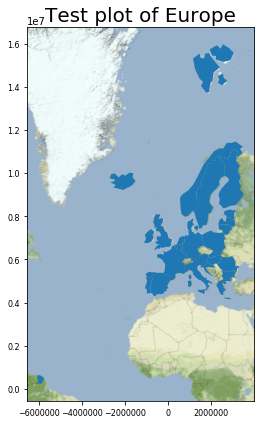

In [25]:
#Test plot for European countries
ax = europe.plot(figsize=(8,6))
plt.title("Test plot of Europe", fontsize=20)

#Settting ticks parameters and layout
plt.tick_params(labelsize=8)
plt.tight_layout(pad=1.08, h_pad=2);

#Adding base map
ctx.add_basemap(ax=ax,url=ctx.sources.ST_TERRAIN_BACKGROUND, zoom=4)

**Observation:** 

As shown above we can see that some countries include territories that is not on the European continent. We need to identify these countries and drop them

In [26]:
europe.loc[europe['name'] == 'Norway']

pop_est continent    name iso_a3  gdp_md_est  \
0  5320045    Europe  Norway    -99    364700.0   
1  5320045    Europe  Norway    -99    364700.0   
2  5320045    Europe  Norway    -99    364700.0   
3  5320045    Europe  Norway    -99    364700.0   

                                            geometry  
0  POLYGON ((1685691.012 15333216.867, 1727962.36...  
1  POLYGON ((3462152.181 10926389.271, 3272742.93...  
2  POLYGON ((3050989.582 15574972.083, 2885918.89...  
3  POLYGON ((2752276.449 14290898.785, 2503610.97...

In [27]:
europe.loc[europe['name'] == 'France']

pop_est continent    name iso_a3  gdp_md_est  \
4  67106161    Europe  France    -99   2699000.0   
5  67106161    Europe  France    -99   2699000.0   
6  67106161    Europe  France    -99   2699000.0   

                                            geometry  
4  POLYGON ((-5750519.703 463075.975, -5816369.64...  
5  POLYGON ((688658.040 6353928.606, 741190.730 6...  
6  POLYGON ((973601.285 5255538.415, 1045290.113 ...

After further investigation we identified that Norway and France are the countries that have territories outside of the European continent. Shown in the output above, geometry value are out of range from the test map above. These rows from the France and Norway need to be dropped. We are do this by using the index.

In [28]:
#Dropping the index, where the isolated territories were identified
europe.drop(index= [0,2,3,4] , axis=0, inplace=True)

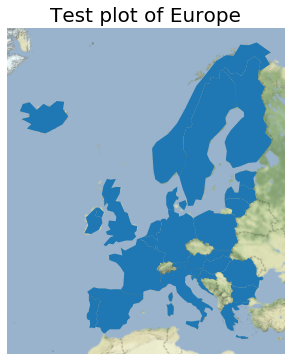

In [29]:
#Test plot 
ax = europe.plot(figsize=(6,6))
plt.title("Test plot of Europe", fontsize=20)

#Adding base map
ctx.add_basemap(ax=ax,url=ctx.sources.ST_TERRAIN_BACKGROUND, zoom=4)

#remove axes
ax.set_axis_off();

Now we have the correct data frame for plotting, we are going to merge it with our outbreaks datasets.

#### Combined data frames

In [30]:
#Checking the shape of each data frame and type of each data frame 
print(f"There are {outbreak.shape[0]} rows and {outbreak.shape[1]} columns in outbreak data set, which is {type(outbreak)}")
print(f"There are {europe.shape[0]} rows and {europe.shape[1]} columns in outbreak data set, which is {type(europe)}")

There are 25787 rows and 6 columns in outbreak data set, which is <class 'pandas.core.frame.DataFrame'>
There are 33 rows and 6 columns in outbreak data set, which is <class 'geopandas.geodataframe.GeoDataFrame'>


Combining both outbreak with map GeoPandas data frame 

In [31]:
merge_df = pd.merge(europe, outbreak, how='left', left_on='name',  right_on='regionname')

In [32]:
merge_df.head()

pop_est continent    name iso_a3  gdp_md_est  \
0  5320045    Europe  Norway    -99    364700.0   
1  5320045    Europe  Norway    -99    364700.0   
2  5320045    Europe  Norway    -99    364700.0   
3  5320045    Europe  Norway    -99    364700.0   
4  5320045    Europe  Norway    -99    364700.0   

                                            geometry           indicator  \
0  POLYGON ((3462152.181 10926389.271, 3272742.93...  Notification rate    
1  POLYGON ((3462152.181 10926389.271, 3272742.93...  Notification rate    
2  POLYGON ((3462152.181 10926389.271, 3272742.93...  Notification rate    
3  POLYGON ((3462152.181 10926389.271, 3272742.93...  Notification rate    
4  POLYGON ((3462152.181 10926389.271, 3272742.93...  Notification rate    

        unit       time regioncode regionname  numvalue  
0  N/1000000 1999-01-01         NO     Norway       0.0  
1  N/1000000 1999-02-01         NO     Norway       0.0  
2  N/1000000 1999-03-01         NO     Norway       0.0  
3  N/1000000 1999-04-01         NO     Norway       0.0  
4  N/1000000 1999-05-01         NO     Norway       0.0

In [33]:
#Filtering through data frame to receive reported confirmed cases (outbreaks)
reported = merge_df[merge_df['indicator'] == 'Reported confirmed cases']

After obtaining the reported confirmed cases of measles outbreaks we are going to filter through the date to obtain the outbreaks from 2018 and 2019

In [34]:
#Filtering through date
reported = reported[reported['time'] > datetime.date(2017,12,1)]

#Sorting values
reported.sort_values('numvalue', ascending = False).head()

pop_est continent     name iso_a3  gdp_md_est  \
6540   21529967    Europe  Romania    ROU    441000.0   
6541   21529967    Europe  Romania    ROU    441000.0   
6539   21529967    Europe  Romania    ROU    441000.0   
6543   21529967    Europe  Romania    ROU    441000.0   
21727  62137802    Europe    Italy    ITA   2221000.0   

                                                geometry  \
6540   POLYGON ((3142944.799 5698722.044, 3192618.449...   
6541   POLYGON ((3142944.799 5698722.044, 3192618.449...   
6539   POLYGON ((3142944.799 5698722.044, 3192618.449...   
6543   POLYGON ((3142944.799 5698722.044, 3192618.449...   
21727  POLYGON ((969591.727 4997600.566, 1025253.828 ...   

                      indicator unit       time regioncode regionname  \
6540   Reported confirmed cases    N 2018-03-01         RO    Romania   
6541   Reported confirmed cases    N 2018-04-01         RO    Romania   
6539   Reported confirmed cases    N 2018-02-01         RO    Romania   
6543   Reported confirmed cases    N 2018-06-01         RO    Romania   
21727  Reported confirmed cases    N 2018-04-01         IT      Italy   

       numvalue  
6540     1050.0  
6541      963.0  
6539      580.0  
6543      472.0  
21727     381.0

We are going to create a Choropleth map from the number of confirmed cases in 2018 and 2019. 

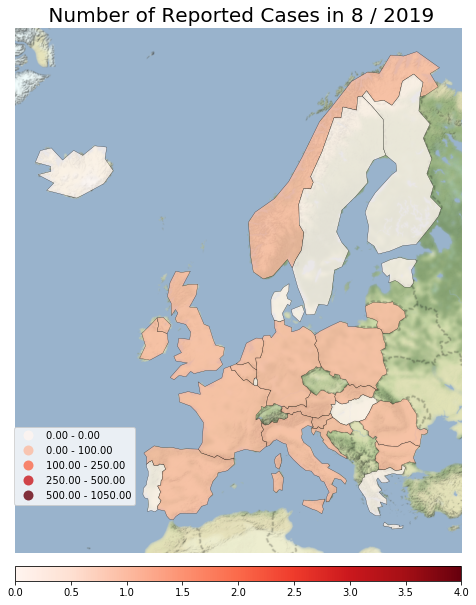

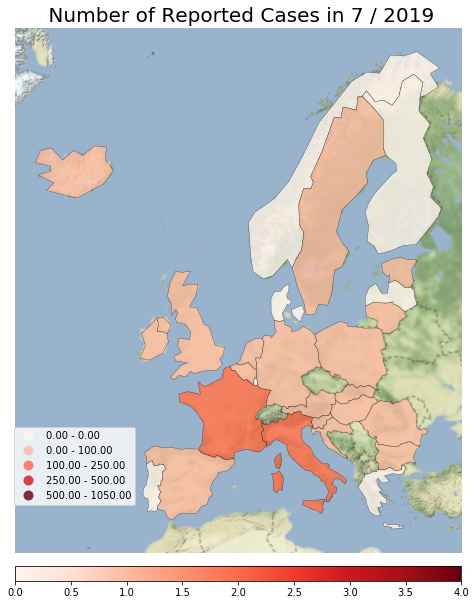

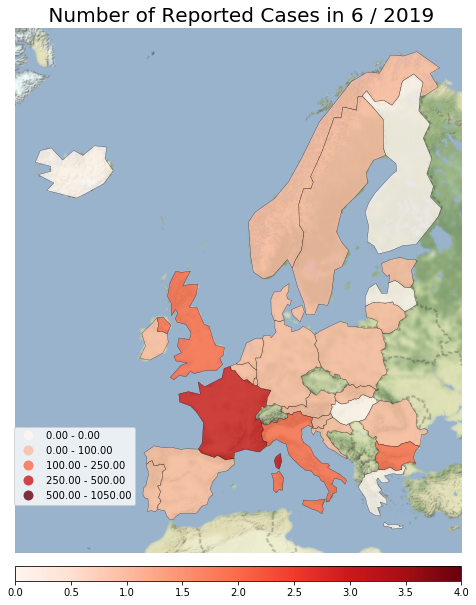

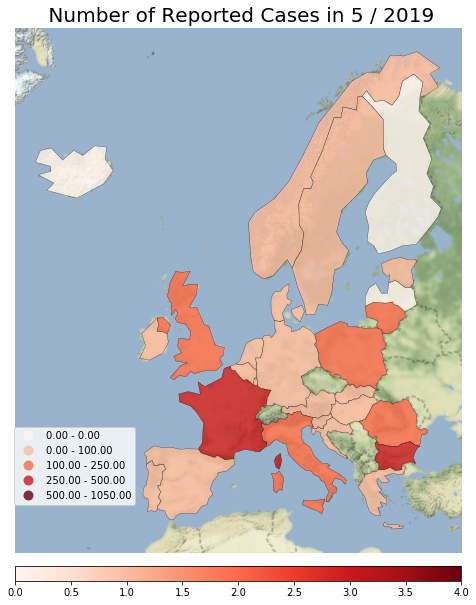

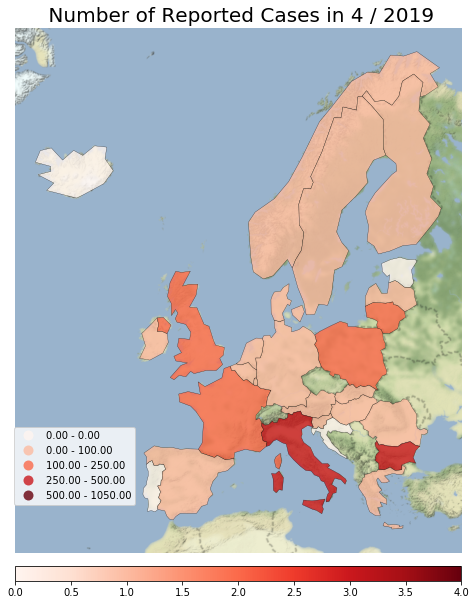

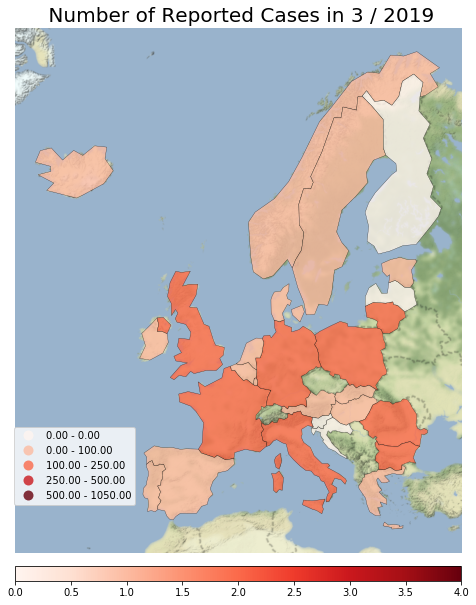

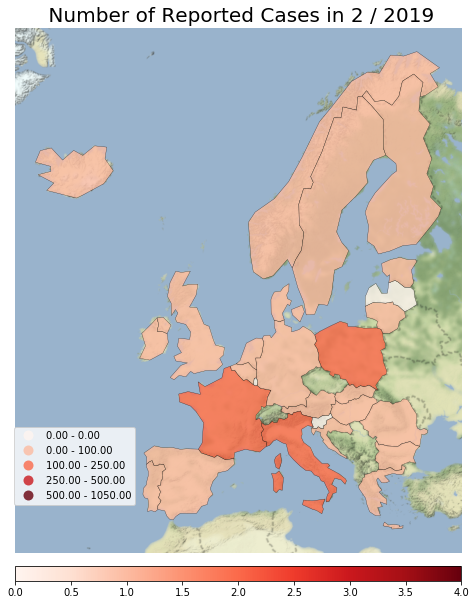

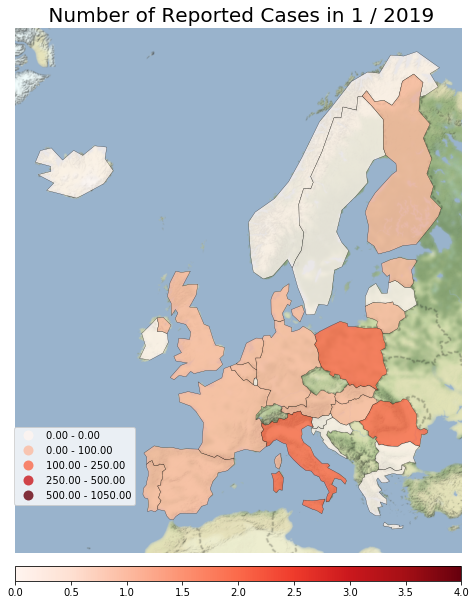

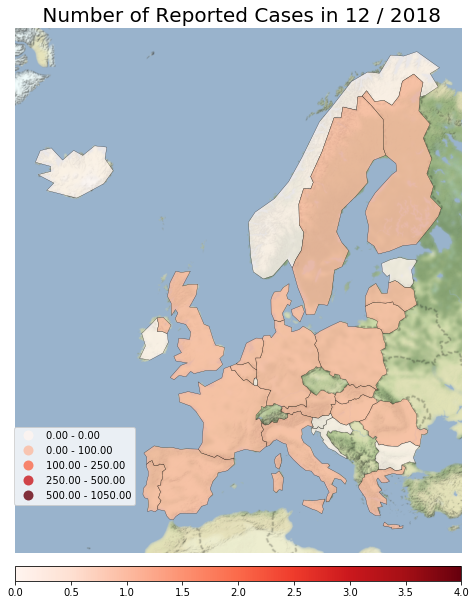

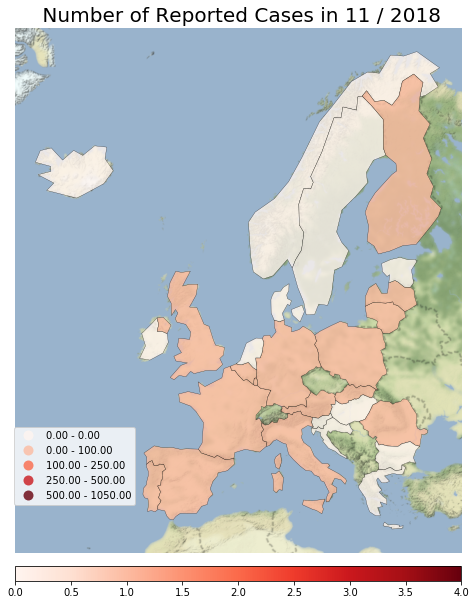

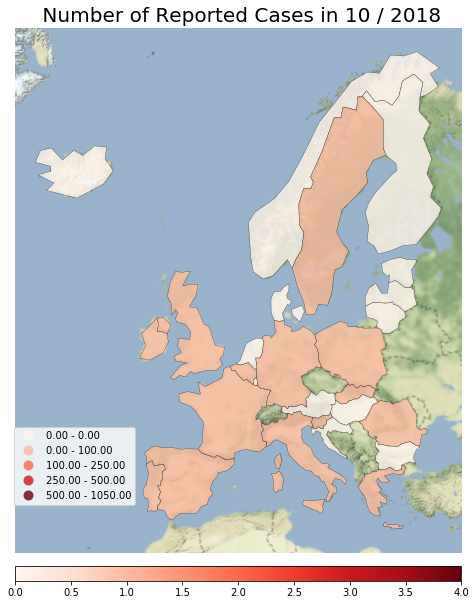

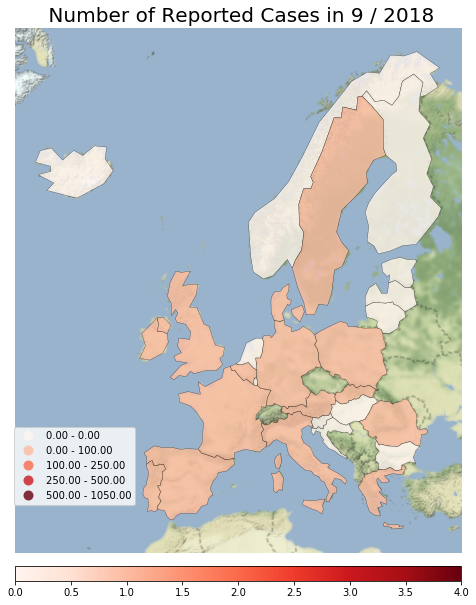

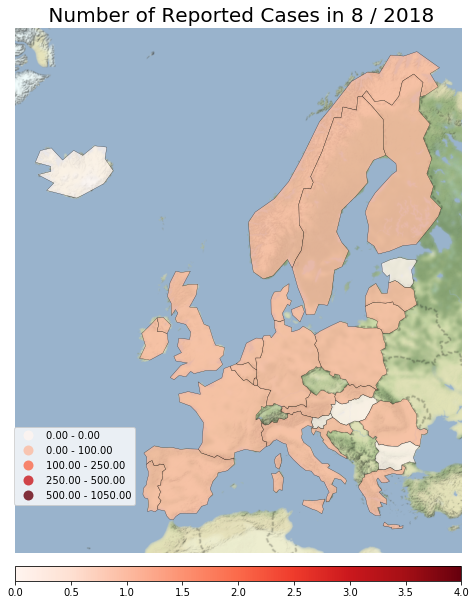

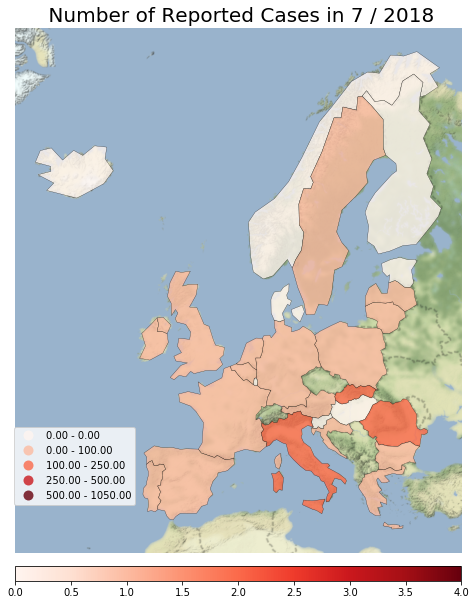

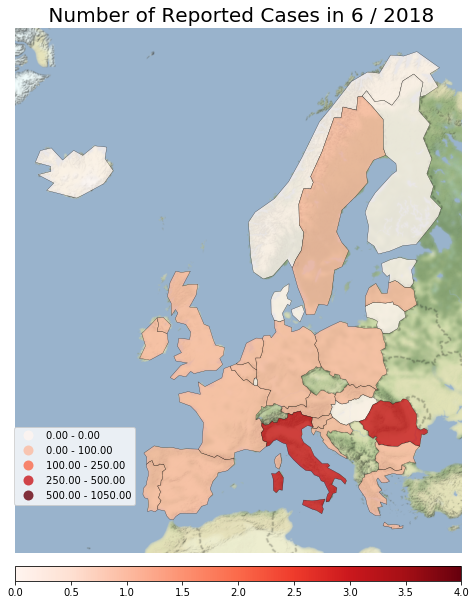

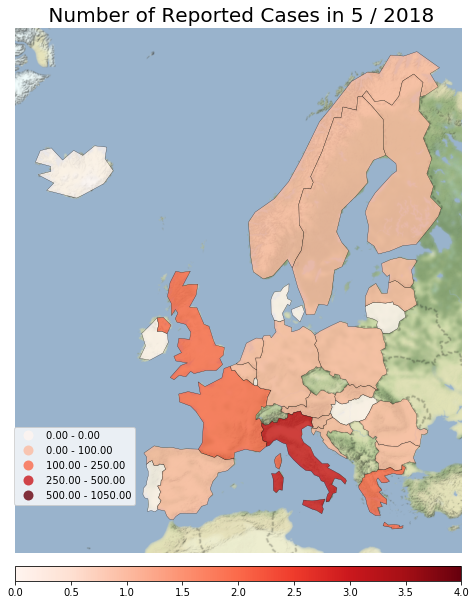

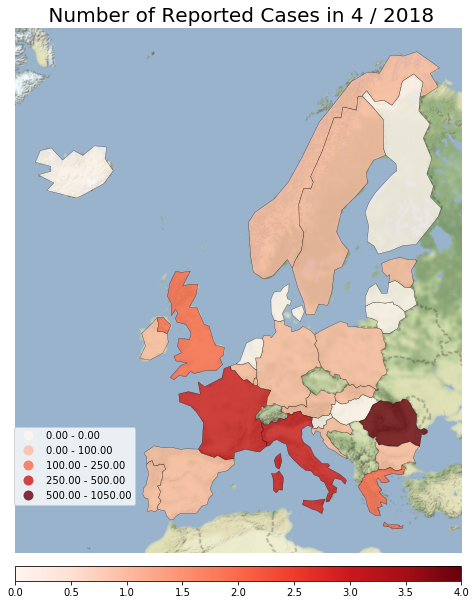

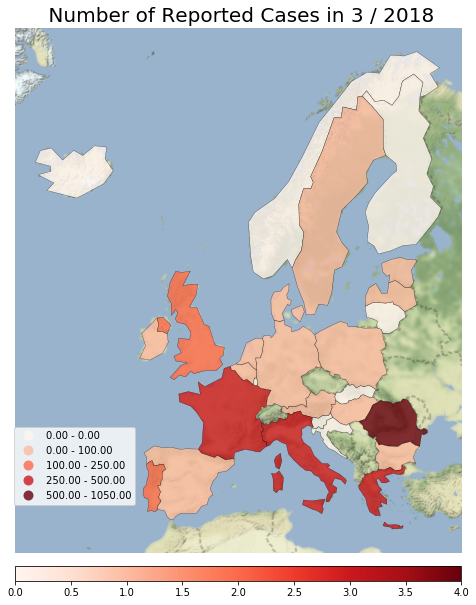

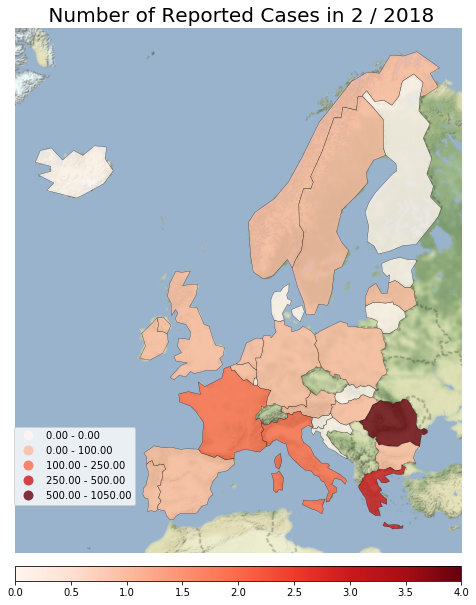

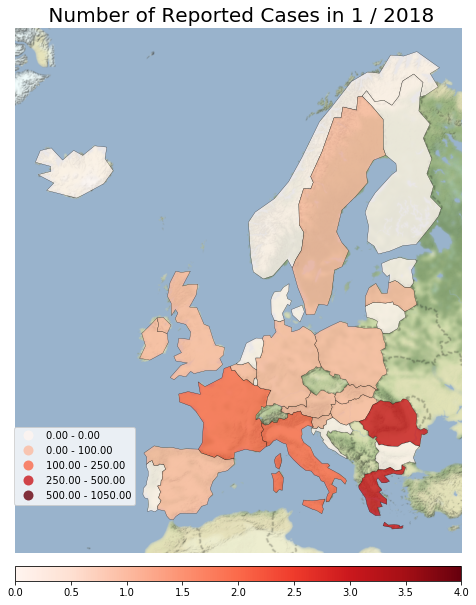

In [35]:
#Creating a list of dates 
date_list = list(set(reported['time']))
date_list.sort(reverse = True)

#Defining legend list
bins_list= [0, 100, 250, 500, reported['numvalue'].max()]

#Setting the range for the choropleth values
vmin, vmax = 0, 4

for index, date in enumerate(date_list):
    
    #Create figure and axes for Matplotlib
    fig, ax = plt.subplots(1, figsize=(8, 12))
    
    #Create colorbar legend
    sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    
    #Empty array for the data range
    sm.set_array([]) 
    
    #Add the colorbar to the figure
    fig.colorbar(sm, orientation="horizontal", fraction=0.030, pad=0.02, aspect = 30, ax=ax)
    
    #Creating monthly data frame 
    month_df = reported[reported['time'] == date]
    
    #Creating plot 
    month_df.plot(column='numvalue',
                       cmap = 'Reds',
                       edgecolor = 'k',
                       alpha=0.8, 
                       linewidth = 0.3,
                       ax=ax, 
                       scheme='UserDefined', 
                       classification_kwds= dict(bins=bins_list), 
                       vmin=vmin,
                       vmax=vmax, 
                       legend=True)     
    
    ctx.add_basemap(ax=ax,url=ctx.sources.ST_TERRAIN_BACKGROUND, zoom=4)
    
    #Adding title to map
    ax.set_title(f" Number of Reported Cases in {date.month} / {date.year}", fontdict= {'fontsize':20, 'fontweight' : '1'})
    
    #Adding legend
    ax.get_legend().set_bbox_to_anchor((.28,.25))

    #Removing axes
    ax.set_axis_off()
    
    #Creating filename
    file_name = (4-len(str(index)))*'0'+str(index)

    #Saving the plot to the images folder 
    plt.savefig(f'../images/timelapse/{file_name}_map.png',bbox_inches='tight');

This creates a gif based on the images that we generated above. 

In [36]:
#Credit to Nick Read and Noah Christiansen with slight modification

#Creating a dictionary 
png_dir = '../images/timelapse/'
images = []
dir_list = os.listdir(png_dir)

#Sorting the images into 000->064
dir_list.sort()

#Iterating through the images to make the gif
for file_name in dir_list:
    if file_name.endswith('.png'):
        file_path = os.path.join(png_dir, file_name)
        images.append(imageio.imread(file_path))

#Saving gif
imageio.mimsave('../images/map.gif', images, fps = 5,  duration=1.5)

Next, we are going to start our time series model with our data and our target country, Germany. Germany was identified to be the most suited country for our time series model during our EDA.